# Fitting to empirical data

This notebook is used to generate maximum likelihood estimates for the parameters of a dynamic model judging from empirically collected data. It's used to produce Table 1, Figure 4, and supplemental contour figures in the accompanying paper.

## Google Colab initialization

This section will help you interface with Google Drive and clone the git repository where the code lives. These steps **aren't necessary if you are running locally**. First, make sure you have opened the notebook in Google Colab (use the below button if ncessary) and logged into your Google account.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/tanderson11/covid_households/blob/main/notebooks/EmpiricalFits.ipynb)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
%mkdir /content/gdrive/My\ Drive/github/
%cd /content/gdrive/My\ Drive/github/
# Thayer has his files located here instead
#%cd /content/gdrive/My\ Drive/github/paper_push


In [ ]:
# If you've forked the repository, point to your own username and repository name (if different)
repo_owner="tanderson11"
repository="covid_households"

!git config --global user.email "tanderson11@gmail.com"
!git config --global user.name "Thayer Anderson"

In [ ]:
!git clone https://github.com/tanderson11/covid_households.git

In [ ]:
%cd covid_households/
!ls -a

# >>> TOKEN SETUP: <<<
# this will put your token in the right folder; comment this line out after use to avoid an error message
#!mv ../git_token.py ./
#!cp ../../covid_households/git_token.py ./

#from git_token import git_token

In [ ]:
!git checkout main
!git pull

In [ ]:
%cd ./notebooks

## Module initialization

In [1]:
import numpy as np
import os
import pandas as pd
import pyarrow.parquet as pq
%cd ../covid_households
import likelihood
import recipes

/Users/thayer/develop/covid_households/covid_households


## Loading empirical and simulated datasets

In [2]:
root = os.path.abspath(os.path.dirname(os.path.abspath('')))
results = recipes.Results.load(os.path.join(root, 'new_parameters/gillespie-s80-p80-SAR/beta_corrections'))
results.find_frequencies(inplace=True)

keys = results.metadata.parameters
keys

['s80', 'p80', 'SAR']

In [54]:
# load the data as a pandas dataframe
population_name = 'Ontario'
if population_name == 'Ontario':
    empirical_df = os.path.join(root, "empirical/Ontario/empirical_df.parquet")
    empirical_df = pq.read_table(empirical_df).to_pandas()
elif population_name == 'Bnei Brak':
    results = recipes.Results.load(os.path.join(root, 'new_parameters/gillespie-s80-p80-SAR/beta_corrections/high_sizes'))
    results.find_frequencies(inplace=True)

    dfs = []
    n_random_dfs = 20
    for i in range(n_random_dfs):
        randomized_df_path = os.path.join(root, f"empirical/BneiBrak/randomized_corrections/randomized_df{i}.parquet")
        randomized_df = pq.read_table(randomized_df_path).to_pandas()
        dfs.append(randomized_df)
    empirical_df = pd.concat(dfs)
    print(empirical_df)
    true_path = os.path.join(root, f"empirical/BneiBrak/empirical_df.parquet")
    bnei_brak_true_hhs = pq.read_table(true_path).to_pandas()
elif population_name == 'Geneva':
    empirical_df = os.path.join(root, "empirical/geneva/empirical_df.parquet")
    empirical_df = pq.read_table(empirical_df).to_pandas()
else:
    assert ValueError("population name is not recognized.")

# the infections column should be integer values
empirical_df['infections'] = empirical_df['infections'].round(0)
empirical_df = empirical_df.astype({'infections': 'int32', 'size': 'int32'})

# for the different parameter values, we don't know their true value, so let's give them the dummy value of 0.
for key in keys:
    empirical_df[key] = 0.

# turn the list of households into counts of the number of infections in different households
empirical_counts = likelihood.counts_from_empirical(empirical_df, keys, sample_only_keys=[])

if population_name == 'Bnei Brak':
    empirical_counts = empirical_counts[empirical_counts.index.get_level_values('size') <= 15]
    empirical_counts = empirical_counts / 20
empirical_counts.tail(50)

sample s80  sample p80  sample SAR  size  infections
0.0         0.0         0.0         2     1             5526
                                          2             1399
                                    3     1             4523
                                          2             1053
                                          3              634
                                    4     1             4854
                                          2             1421
                                          3              766
                                          4              511
                                    5     1             2845
                                          2              668
                                          3              455
                                          4              284
                                          5              228
                                    6     1             1332
                                

In [62]:
def total_secondary_contacts(empirical_counts):
    counts = empirical_counts.reset_index()
    return ((counts['size'] - 1) * counts['count']).sum()

def secondary_contacts_infected(empirical_counts):
    counts = empirical_counts.reset_index()
    return ((counts['infections'] - 1) * counts['count']).sum()

n = total_secondary_contacts(empirical_counts)
X = secondary_contacts_infected(empirical_counts)

n,X

(80905, 15731)

In [61]:
def sep(n, X):
    p_hat = X/n
    q_hat = 1 - p_hat
    sep = np.sqrt(p_hat * q_hat/n)

    return sep

# Careful not to use the randomized Bnei Brak data. Here are the actual results:
# Bnei Brak: secondary contacts infected = 975
# Bnei Brak: total # secondary contacts = 2716

sep(n,X) * 2 * 100

0.2782801994778203

In [15]:
empirical_counts

sample s80  sample p80  sample SAR  size  infections
0.0         0.0         0.0         2     1             69.65
                                          2             88.35
                                    3     1             31.45
                                          2             29.90
                                          3             24.65
                                                        ...  
                                    13    9              0.85
                                          10             0.25
                                          11             0.10
                                          12             0.85
                                          13             0.25
Name: count, Length: 89, dtype: float64

Sometimes for fun, we want to look at the best fit under a "null hypothesis" of no heterogeneity. In order to do that, we need to select the results of our simulations that have no heterogeneity ($s_{80} = p_{80} = 80\%$)

In [16]:
freq = results.df['frequency']
s80_l = freq.index.get_level_values(0)
p80_l = freq.index.get_level_values(1)

null_freqs = freq[(s80_l == 0.8) & (p80_l == 0.8)]
null_freqs

s80  p80  SAR   size  infections
0.8  0.8  0.01  2     1             0.989690
                      2             0.010310
                3     1             0.979630
                      2             0.019695
                      3             0.000675
                                      ...   
          0.60  13    9             0.000000
                      10            0.000000
                      11            0.000000
                      12            0.000000
                      13            0.999420
Name: frequency, Length: 5400, dtype: float64

## Constructing likelihood surface and finding MLEs

By default, the log likelihood is held in a `Series` of log likelihood values organized around a 4-level index. The first index represent which empirical trial corresponds to that section of data. The next three parameters correspond to the parameter values at which we are estimating the likelihood (ie the model parameters).

In [17]:
# calculate the log likelihood using the table of frequencies calculated over many households and the empirical counts from the dataset
logl = likelihood.logl_from_frequencies_and_counts(results.df['frequency'], empirical_counts, keys)
# by default indexed by a 'trial' index, but there is only one trial (the 0th) because this is a single dataset
logl = logl.loc[0]
logl

/Users/thayer/develop/covid_households/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


s80   p80   SAR 
0.02  0.02  0.01   -2988.367849
            0.02   -2534.721831
            0.03   -2268.822545
            0.04   -2086.948325
            0.05   -1948.833020
                       ...     
0.80  0.80  0.11   -1389.691924
            0.12   -1408.008780
            0.13   -1429.930997
            0.14   -1456.941840
            0.15   -1488.610105
Name: logl, Length: 70071, dtype: float64

In [18]:
# "profile" likelihood: looking at fixing two parameters at the MLE and trying to get 95% confidence in the last one
in_95 = likelihood.normalize_probability(logl).sort_values(ascending=False).head()
in_95
#s80s = list(zip(*[i for i in in_95]))
#plt.hist(s80s)

s80   p80   SAR 
0.02  0.80  0.34    0.148464
      0.78  0.34    0.107347
      0.80  0.35    0.099099
      0.78  0.35    0.072849
      0.76  0.34    0.048513
Name: logl, dtype: float64

The parameters of the maximum likelihood estimate are easy to obtain by just finding the maximum value in the table of likelihood values.

In [20]:
mle = logl.idxmax()
keys, mle

(['s80', 'p80', 'SAR'], (0.02, 0.8, 0.34))

In [21]:
null_logl = likelihood.logl_from_frequencies_and_counts(null_freqs, empirical_counts, keys).loc[0]
null_mle = null_logl.idxmax()
null_mle

/Users/thayer/develop/covid_households/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(0.8, 0.8, 0.09)

In [22]:
confidence_95_mask = likelihood.confidence_mask_from_logl(logl, percentiles=(0.95,)).astype('bool')
confidence_95_intervals = [
    likelihood.confidence_interval_from_confidence_mask(confidence_95_mask, 's80'),
    likelihood.confidence_interval_from_confidence_mask(confidence_95_mask, 'p80'),
    likelihood.confidence_interval_from_confidence_mask(confidence_95_mask, 'SAR'),
]
keys, confidence_95_intervals

(['s80', 'p80', 'SAR'], [(0.02, 0.06), (0.64, 0.8), (0.31, 0.37)])

## Bar graphs of empirically observed infections and best fit simulated infections

To construct these graphs, we have to organize the empirical data and the simulated data into a single DataFrame and then plot the observed/expected infections.

In [23]:
# the frequencies at the mle give the proportions of different # of infections in the best fit from the model
best_fit_infections = results.df.loc[mle]['frequency']
best_fit_infections.name = "model"
best_fit_infections

size  infections
2     1             0.830815
      2             0.169185
3     1             0.646620
      2             0.237180
      3             0.116200
                      ...   
13    9             0.113105
      10            0.177915
      11            0.226505
      12            0.204210
      13            0.101325
Name: model, Length: 90, dtype: float64

In [24]:
# the frequencies at the null hypothesis mle give the proportions of different # of infections in the best fit from the model
null_fit_infections = results.df.loc[null_mle]['frequency']
null_fit_infections.name = "null model"

In [25]:
# the empirical data is observed counts, we convert that to frequencies by dividing the counts by the total number of households of that size
empirical_frequencies = empirical_counts/(empirical_counts.groupby(['sample ' + k for k in keys]+["size"]).sum())
empirical_frequencies.name = 'data'
# we have to index past the dummy key values that we assigned earlier for each parameter in the empirical dataset
empirical_frequencies = empirical_frequencies.loc[0.0, 0.0, 0.0]
empirical_frequencies

size  infections
2     1             0.440823
      2             0.559177
3     1             0.365698
      2             0.347674
      3             0.286628
                      ...   
13    9             0.106250
      10            0.031250
      11            0.012500
      12            0.106250
      13            0.031250
Name: data, Length: 89, dtype: float64

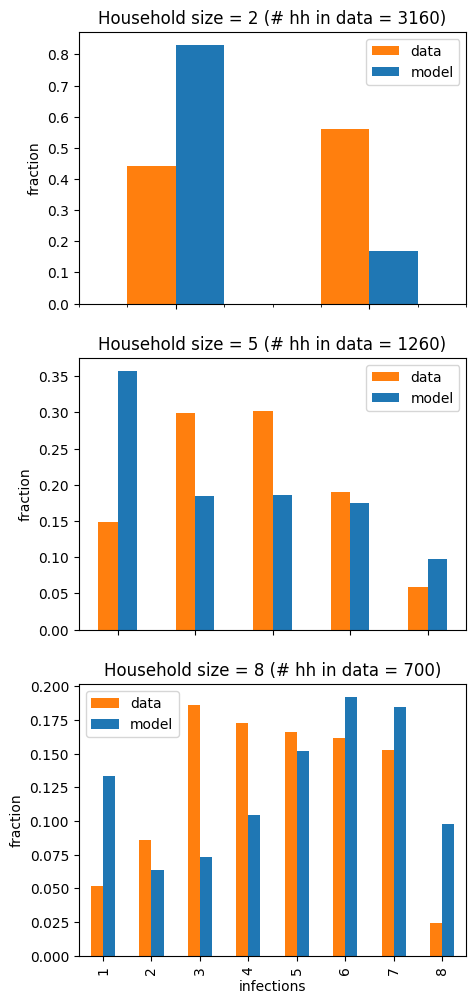

In [26]:
import matplotlib.pyplot as plt
include_null = False
if include_null:
    combined_best_and_empirical = pd.concat([empirical_frequencies, best_fit_infections, null_fit_infections], axis=1)
else:
    combined_best_and_empirical = pd.concat([empirical_frequencies, best_fit_infections], axis=1)
empirical_sizes = empirical_df.groupby('size').size()
n_sizes = len(empirical_sizes.index.unique())

which_sizes = empirical_sizes.index.unique()
which_sizes = [2, 5, 8]

vertical = True

n_cols = 3
n_rows = int(np.ceil(len(which_sizes) / n_cols))

if vertical:
    n_cols, n_rows = n_rows, n_cols


fixed_ylims = False
ylims_by_household_size = {
    2: 6000,
    5: 3000,
    8: 300
}

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols)
axis_generator = (ax for ax in np.ravel(axes))
cmap = plt.get_cmap("tab10")
color_dict = {'model': cmap(0), 'data': cmap(1), 'null model':cmap(2)}
for k,g in combined_best_and_empirical.groupby('size'):
    if k not in which_sizes:
        continue
    try:
        ax = next(axis_generator)
    except StopIteration:
        break
    try:
        title = f"Household size = {k} (# hh in data = {empirical_sizes[k]})"
    except KeyError:
        continue
    g = g.set_index(g.index.droplevel('size')) * empirical_sizes[k]
    g = g / g.sum()
    g.plot.bar(
        ax=ax,
        figsize=(5*n_cols,n_rows*4),
        title=title,
        xlabel="infections",
        ylabel="fraction",
        sharex=True,
        color=color_dict,
    ),
    if fixed_ylims:
        ax.set_ylim((0,  ylims_by_household_size[k]))
    #plt.ylim((0,6000))

plt.savefig(f'../figures/{population_name}_data.pdf', dpi=400, bbox_inches='tight')

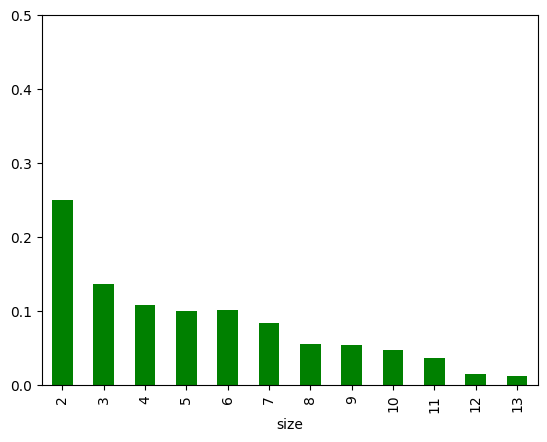

In [27]:
ecounts = empirical_counts.loc[0.0, 0.0, 0.0]
(ecounts.groupby('size').sum()/(ecounts.groupby('size').sum().sum())).plot.bar(color='green')
plt.ylim(0, 0.5)
plt.savefig(f'../figures/{population_name}_household_histogram.pdf', dpi=400, bbox_inches='tight')

## Contours of the likelihood surface for a given parameter

In [30]:
prob_df = likelihood.normalize_probability(logl)
prob_df = prob_df.groupby(['s80', 'SAR']).sum()
prob_df = prob_df / prob_df.sum()

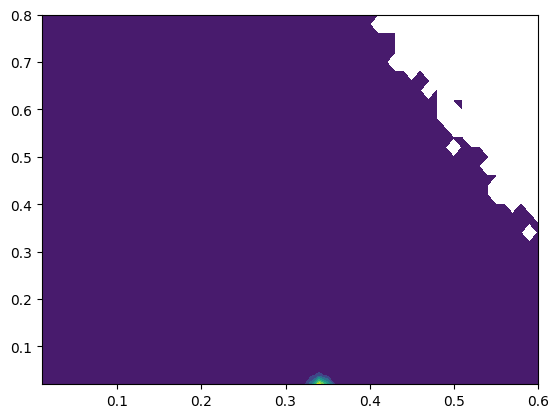

In [31]:
Z = prob_df.unstack()

X,Y = np.meshgrid(Z.columns, Z.index)
#print(self.kwargs)
contourf = plt.contourf(X, Y, Z)